In [1]:
import empylib.rad_transfer as rt
import empylib.nklib as nk
import numpy as np
import matplotlib.pyplot as plt

For radiative transfer we rely on two libraries:
- ```rad_transfer``` with functions for simple calculations (e.g., Beer–Lambert)
- ```iadpython``` for multiple‑scattering simulations

## Beer–Lambert (```T_beer_lambert```)
The function ```T_beer_lambert``` in ```empylib.rad_transfer``` uses Beer-Lambert law to compute total/specular transmittance and total reflectance through a slab of thickness $d$ containing inclusions.


In [2]:
help(rt.T_beer_lambert)

Help on function T_beer_lambert in module empylib.rad_transfer:

T_beer_lambert()
       Transmittance and reflectance from Beer-Lamberts law for a film with 
       spherical particles. Reflectance is computed from classical formulas for
       incoherent light incident on a slab between two semi-infinite media 
       (no scattering is considered for this parameter)
    
    Parameters
       ----------
       lam : array-like, shape (nλ,)
           Wavelengths [µm], strictly positive.
    
       Nh : float or array-like (nλ,)
           Host refractive index (can be complex). If array-like, length must equal len(lam).
    
       Np (float, 1darray or list): Complex refractive index of each 
                                               shell layer. Np.shape[1] == len(D). 
           Options are:
           float:   solid sphere and constant refractive index
           1darray: solid sphere and spectral refractive index (len = lam)
           list:    multilayered sphere (with bo

In the next example, we consider a **silica film** with pores; the upper and lower media are air. The light is incident at $\theta_i = 0^\circ$.

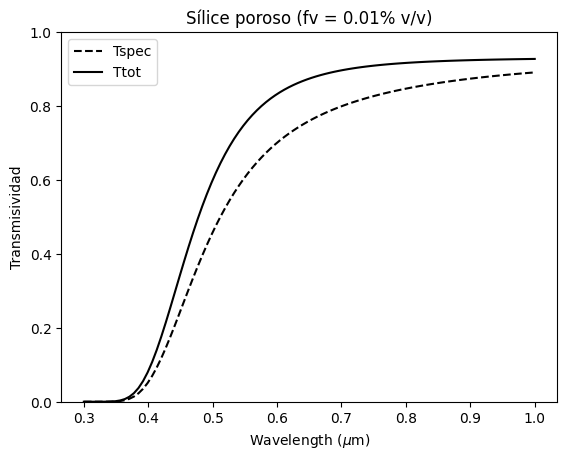

In [3]:
lam = np.linspace(0.3,1.0,100)  # wavelength grid (in microns)
theta = np.radians(0)           # 30 degrees in radians
tfilm = 1.0                     # thickness in mm
Nh = nk.SiO2(lam)               # refractive index: top, slab, bottom
fv = 0.0001                     # volume fraction of pores/inclusions
D = 0.2                         # pore/particle diameter (microns)
Np = 1.0                        # refractive index of inclusions

Ttot, Rtot, Tspec = rt.T_beer_lambert(lam, Nh, Np, D, fv, tfilm,
                                      theta = theta)

plt.plot(lam,Tspec,'--k',label = 'Tspec')
plt.plot(lam,Ttot,'-k',label = 'Ttot')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transmisividad')
plt.title(r'Sílice poroso (fv = 0.01% v/v)')
plt.legend()
plt.ylim(0,1)
plt.show()

## Multiple scattering of spherical particles (```adm_sphere```)

The function ```adm_sphere``` in ```empylib.rad_transfer``` implements the **adding–doubling method (ADM)** to solve the radiative transfer equation (RTE) numerically.


In [4]:
help(rt.adm_sphere)

Help on function adm_sphere in module empylib.rad_transfer:

adm_sphere()
    Parameters
    ----------
    lam : array-like, shape (nλ,)
        Wavelengths [µm], strictly positive.
    
    Nh : float or array-like (nλ,)
        Host refractive index (can be complex). If array-like, length must equal len(lam).
    
    Np (float, 1darray or list): Complex refractive index of each 
                                            shell layer. Np.shape[1] == len(D). 
        Options are:
        float:   solid sphere and constant refractive index
        1darray: solid sphere and spectral refractive index (len = lam)
        list:    multilayered sphere (with both constant or spectral refractive indexes)
    
    D : float, _np.ndarray or list
        Diameter of the spheres. Use float for monodisperse, or array for polydisperse.
        if multilayer sphere, use list of floats (monodisperse) or arrays (polydisperse).
    
    fv : float
        Particle volume fraction in (0, 1). Used only

In the example, we model an **acrilic film (PMMA)** with TiO$_2$ particles using ADM over $\lambda\in[0.3,1.0]$ $\mu$m.

Extrapolating (C5H8O2)n - poly(methyl methacrylate)_Zhang-Tomson refractive index below tabulated range (requested min 0.200 µm; data starts 0.400 µm)


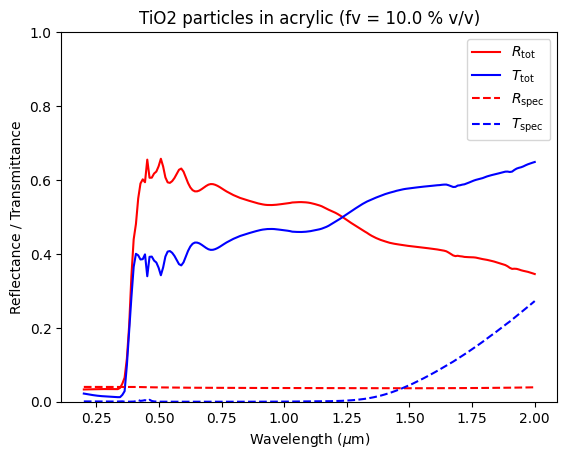

In [5]:
lam = np.linspace(0.2, 2.0, 200) # espectro de longitudes de onda
tfilm = 0.010                    # thickness in mm
Nh = nk.PMMA(lam)                # índice de refracción del medio (agua)
fv = 0.10                        # volume fraction of pores/inclusions
Dp = 0.500                       # particle diameter (microns)
Np = nk.TiO2(lam)                # índice de refracción partícula

Ttot, Rtot, Tspec, Rspec = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm)

plt.plot(lam,Rtot,'-r',label='$R_\mathrm{tot}$')
plt.plot(lam,Ttot,'-b',label='$T_\mathrm{tot}$')
plt.plot(lam,Rspec,'--r',label='$R_\mathrm{spec}$')
plt.plot(lam,Tspec,'--b',label='$T_\mathrm{spec}$')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Reflectance / Transmittance')
plt.title(r'TiO2 particles in acrylic (fv = %.1f %% v/v)' % (fv*100))
plt.legend()
plt.ylim(0,1)
plt.show()

## Special cases for monodispersed particles

By default, `Beer_lambert` and `adm_sphere` consider scattering independent particles and no effective medium. These assumptions, generaly apply well for low volume fraction ($f_v < 1`\%$). Additionally, the scattering direction is based on the asymmetry parameter. Particularly for `adm_sphere`, the phase function is computed using the Henyey-Greenstein model.

To model more realistic scenarios, the following flags can be used:
- `effective_medium=True`: computes scattering efficiencies considering an effective refractive index based on the properties of the host and volume fraction of the inclusions. 
- `use_phase_fun=True`: Uses the phase function to compute scattering efficiencies. This generally improves accuracy, specially for large particles.
- `dependent_scatt=True`: Includes the effects of interference when computing scattering ussing the Perkus-Yevick model.
>**Warning.** Percus-Yevic model does not applies for metallic particles as near-field coupling is not considered.

### Effect of dependent scattering and effective medium theory

In [6]:
# calculations with independent scattering and effective medium
Ttot_eff, Rtot_eff, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     effective_medium=True)

# calculations with dependent scattering and effective medium
Ttot_ds_eff, Rtot_dsds_eff, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     dependent_scatt=True,
                                     effective_medium=True)

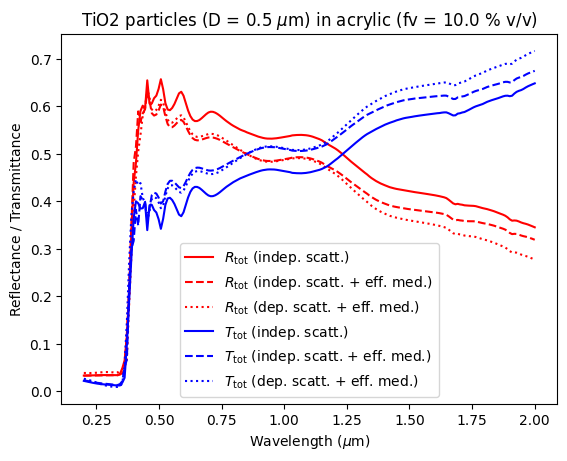

In [7]:
# plotting reflectance
plt.plot(lam,Rtot,'-r',label='$R_\mathrm{tot}$ (indep. scatt.)')
plt.plot(lam,Rtot_eff,'--r',label='$R_\mathrm{tot}$ (indep. scatt. + eff. med.)')
plt.plot(lam,Rtot_dsds_eff,':r',label='$R_\mathrm{tot}$ (dep. scatt. + eff. med.)')

# plotting transmittance
plt.plot(lam,Ttot,'-b',label='$T_\mathrm{tot}$ (indep. scatt.)')
plt.plot(lam,Ttot_eff,'--b',label='$T_\mathrm{tot}$ (indep. scatt. + eff. med.)')
plt.plot(lam,Ttot_ds_eff,':b',label='$T_\mathrm{tot}$ (dep. scatt. + eff. med.)')

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Reflectance / Transmittance')
plt.title(f'TiO2 particles (D = {Dp:.1f} $\mu$m) in acrylic (fv = {fv*100:.1f} % v/v)')
plt.legend()
# plt.ylim(0,1)
plt.show()

### Phase function vs Asymmetry parameter

The asymmetry parameter is used by defaul in all its internal calculations. We can use the phase function of the scattering media, instead, with the argument `use_phase_fun ` to get better accuracy.

Let's compare the results between asymmetry parameter and phase function for the independent and dependent scattering cases. We will set effective media in both.

In [8]:
# case 1: independent scattering with effective medium
Ttot_c1_gcos, Rtot_c1_gcos, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     effective_medium=True)

Ttot_c1_psca, Rtot_c1_psca, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     use_phase_fun=True,
                                     effective_medium=True)

# case 2: dependent scattering with effective medium
Ttot_c2_gcos, Rtot_c2_gcos, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     dependent_scatt=True,
                                     effective_medium=True)

Ttot_c2_psca, Rtot_c2_psca, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     use_phase_fun=True,
                                     dependent_scatt=True,
                                     effective_medium=True)

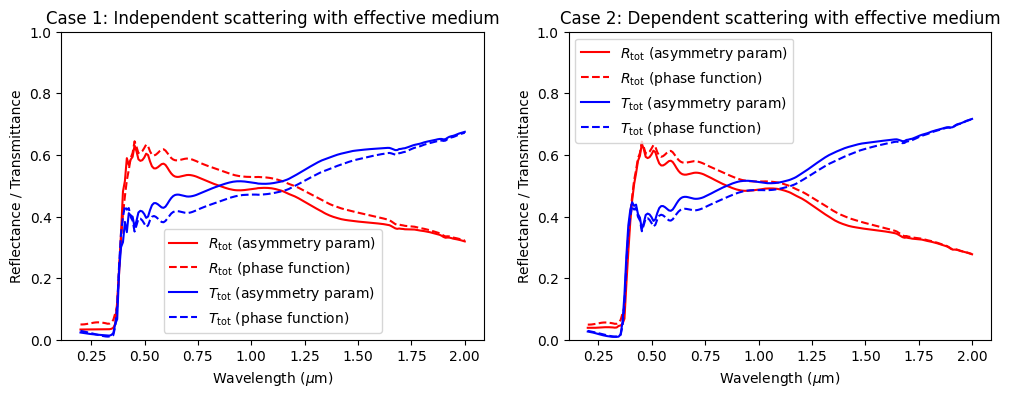

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(lam,Rtot_c1_gcos,'-r',label='$R_\mathrm{tot}$ (asymmetry param)')
ax[0].plot(lam,Rtot_c1_psca,'--r',label='$R_\mathrm{tot}$ (phase function)')
ax[0].plot(lam,Ttot_c1_gcos,'-b',label='$T_\mathrm{tot}$ (asymmetry param)')    
ax[0].plot(lam,Ttot_c1_psca,'--b',label='$T_\mathrm{tot}$ (phase function)')
ax[0].set_title('Case 1: Independent scattering with effective medium')
ax[0].set_xlabel('Wavelength ($\mu$m)')
ax[0].set_ylabel('Reflectance / Transmittance')
ax[0].legend()
ax[0].set_ylim(0,1)

ax[1].plot(lam,Rtot_c2_gcos,'-r',label='$R_\mathrm{tot}$ (asymmetry param)')
ax[1].plot(lam,Rtot_c2_psca,'--r',label='$R_\mathrm{tot}$ (phase function)')
ax[1].plot(lam,Ttot_c2_gcos,'-b',label='$T_\mathrm{tot}$ (asymmetry param)')    
ax[1].plot(lam,Ttot_c2_psca,'--b',label='$T_\mathrm{tot}$ (phase function)')
ax[1].set_title('Case 2: Dependent scattering with effective medium')
ax[1].set_xlabel('Wavelength ($\mu$m)')
ax[1].set_ylabel('Reflectance / Transmittance')
ax[1].legend()
ax[1].set_ylim(0,1)

plt.show()


### Core-shell particles

Both `Beer_lambert` and `adm_sphere` can handle multishelled particles by setting the argument `D` and `Np` in a list format, where 
the first element corresponds to the core, and the following elements to each shell.

All the previous options (`effective_medium`, `dependent_scatt`, `use_phase_function`), can be incorporated into the simulation.

In [10]:
# core-shell dimensions
t_shell = 0.200     # shell thickness in um
De = 1.0            # outer diameter (microns)
Di = De - 2*t_shell # inner diameter (microns)

# core-shell refractive index
Ni = 1.0            # core refractive index (air)
Ne = nk.TiO2(lam)   # shell refractive index (TiO2)

Nh = nk.PMMA(lam)   # host refractive index (PMMA)

# data must be added in list format
Dp = [Di, De]       # list of diameters
Np = [Ni, Ne]       # list of refractive indices


Extrapolating (C5H8O2)n - poly(methyl methacrylate)_Zhang-Tomson refractive index below tabulated range (requested min 0.200 µm; data starts 0.400 µm)


In [11]:
# calculations with independent scattering and no effective medium
Ttot, Rtot, Tspec, Rspec = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm)

# calculations with independent scattering and effective medium
Ttot_eff, Rtot_eff, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     effective_medium=True)

# calculations with dependent scattering and effective medium
Ttot_ds_eff, Rtot_dsds_eff, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                     dependent_scatt=True,
                                     effective_medium=True)

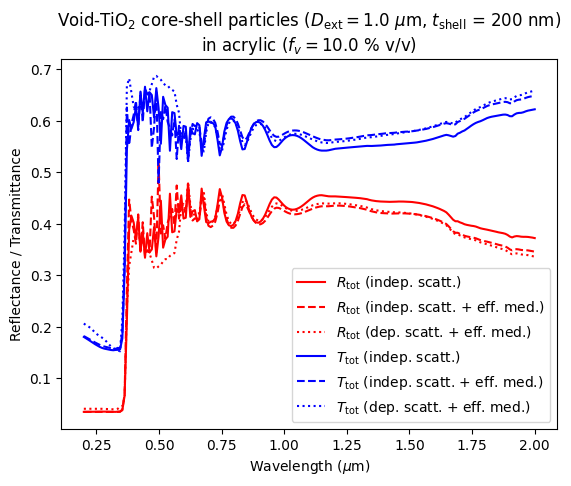

In [12]:
# plotting reflectance
plt.plot(lam,Rtot,'-r',label='$R_\mathrm{tot}$ (indep. scatt.)')
plt.plot(lam,Rtot_eff,'--r',label='$R_\mathrm{tot}$ (indep. scatt. + eff. med.)')
plt.plot(lam,Rtot_dsds_eff,':r',label='$R_\mathrm{tot}$ (dep. scatt. + eff. med.)')

# plotting transmittance
plt.plot(lam,Ttot,'-b',label='$T_\mathrm{tot}$ (indep. scatt.)')
plt.plot(lam,Ttot_eff,'--b',label='$T_\mathrm{tot}$ (indep. scatt. + eff. med.)')
plt.plot(lam,Ttot_ds_eff,':b',label='$T_\mathrm{tot}$ (dep. scatt. + eff. med.)')

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Reflectance / Transmittance')
plt.title(f'Void-TiO$_2$ core-shell particles ($D_\mathrm{{ext}} = ${De:.1f} $\mu$m, $t_\mathrm{{shell}}$ = {t_shell*1E3:.0f} nm)\nin acrylic ($f_v = ${fv*100:.1f} % v/v)')
plt.legend()
# plt.ylim(0,1)
plt.show()

## Polydispersed particles

Both, `adm_sphere` and `beee_lambert` enable to simulate polydispersed medium using the `size_dist` argument. For this cases, the length of `size_dist` and `D` must be equal. 

> **Note.** The size distribution is normalized internally to ensure $\sum_i p_i(D_i) = 1$, where $p_i$ is the probability number of diameters $D_i$

In [13]:
from scipy.stats import norm
fv = 0.10                                                   # volume fraction of pores/inclusions
mean_D = 1.0                                                # mean diameter (microns)
std_D = 0.2                                                 # standard deviation (microns)
Dp = np.linspace(mean_D - 3*std_D, mean_D + 3*std_D, 50)    # diameter range
pi = norm.pdf(Dp, mean_D, std_D)                            # computing probability distribution

Np = nk.TiO2(lam)                                           # refractive index of particles
Nh = nk.PMMA(lam)                                           # refractive index of host

Extrapolating (C5H8O2)n - poly(methyl methacrylate)_Zhang-Tomson refractive index below tabulated range (requested min 0.200 µm; data starts 0.400 µm)


In [14]:
# case 1: independent scattering 
Tt_c1, Rt_c1, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                               size_dist=pi)

# case 2: independent scattering + effective medium
Tt_c2, Rt_c2, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                               size_dist=pi,
                                               effective_medium=True)

# case 3: independent scattering + effective medium + phase function
Tt_c3, Rt_c3, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                               size_dist=pi,
                                               effective_medium=True,
                                               use_phase_fun=True)

# case 4: Effective medium + phase function + dependent scattering
Tt_c4, Rt_c4, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                               size_dist=pi,
                                               effective_medium=True,
                                               use_phase_fun=True,
                                               dependent_scatt=True)

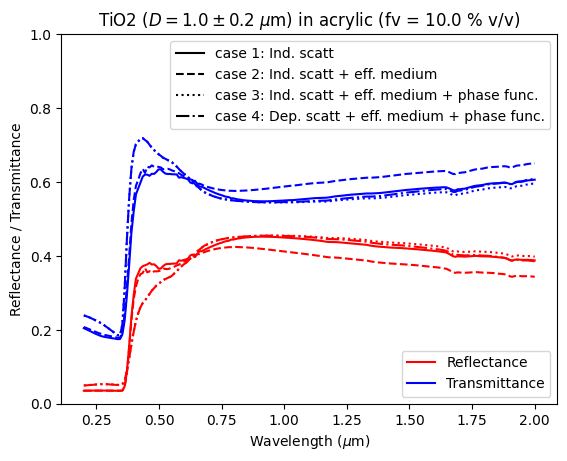

In [15]:
R_out = [Rt_c1, Rt_c2, Rt_c3, Rt_c4]
T_out = [Tt_c1, Tt_c2, Tt_c3, Tt_c4]
style = ['-','--',':','-.']
case_labels = ['case 1: Ind. scatt', 
               'case 2: Ind. scatt + eff. medium', 
               'case 3: Ind. scatt + eff. medium + phase func.', 
               'case 4: Dep. scatt + eff. medium + phase func.']

# Plot data
for i in range(len(R_out)):
    plt.plot(lam, R_out[i], linestyle=style[i], color='r')
    plt.plot(lam, T_out[i], linestyle=style[i], color='b')

# Create custom legend elements
from matplotlib.lines import Line2D

# Legend elements for cases (line styles)
case_elements = [Line2D([0], [0], color='black', linestyle=style[i], label=case_labels[i]) 
                 for i in range(len(style))]

# Legend elements for properties (colors)
prop_elements = [Line2D([0], [0], color='r', label='Reflectance'),
                 Line2D([0], [0], color='b', label='Transmittance')]

# Create legends
legend1 = plt.legend(handles=case_elements, loc='upper right')
legend2 = plt.legend(handles=prop_elements, loc='lower right')

# Add first legend back
plt.gca().add_artist(legend1)

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Reflectance / Transmittance')
plt.title(f'TiO2 ($D = {mean_D}\\pm{std_D}$ $\\mu$m) in acrylic (fv = {fv*100:.1f} % v/v)')
plt.ylim(0,1)
plt.show()

Similarly, we can simulate core-shell particles with polydispersed size distribution

In [16]:
from scipy.stats import norm
fv = 0.10                                                    # volume fraction of pores/inclusions
t_of_R = 2.0/5.0                                             # thickness-to-radius ratio

mean_D1 = 0.6                                                # mean inner diameter (microns)
std_D1 = 0.2                                                 # standard deviation of inner diameter (microns)
D1 = np.linspace(mean_D1 - 2*std_D1, mean_D1 + 2*std_D1, 50) # inner diameter range
N1 = 1.0                                                     # refractive index of core

mean_D2 = mean_D1*(1+t_of_R*2)                               # mean outer diameter (microns)
std_D2 = 0.2                                                 # standard deviation of outer diameter (microns)
D2 = np.linspace(mean_D2 - 2*std_D2, mean_D2 + 2*std_D2, 50) # outer diameter range
N2 = nk.TiO2(lam)                                            # refractive index of shell

pi = norm.pdf(D2, mean_D2, std_D2)                           # computing probability distribution

Dp = [D1, D2]                                                # list of diameters
Np = [N1, N2]                                                # list of refractive indices
Nh = nk.PMMA(lam)                                            # refractive index of host

Extrapolating (C5H8O2)n - poly(methyl methacrylate)_Zhang-Tomson refractive index below tabulated range (requested min 0.200 µm; data starts 0.400 µm)


In [17]:
# case 1: independent scattering 
Tt_c1, Rt_c1, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                               size_dist=pi)

# case 2: independent scattering + effective medium
Tt_c2, Rt_c2, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                               size_dist=pi,
                                               effective_medium=True)

# case 3: independent scattering + effective medium + phase function
Tt_c3, Rt_c3, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                               size_dist=pi,
                                               effective_medium=True,
                                               use_phase_fun=True)

# case 4: Effective medium + phase function + dependent scattering
Tt_c4, Rt_c4, *_ = rt.adm_sphere(lam, Nh, Np, Dp, fv, tfilm,
                                               size_dist=pi,
                                               effective_medium=True,
                                               use_phase_fun=True,
                                               dependent_scatt=True)

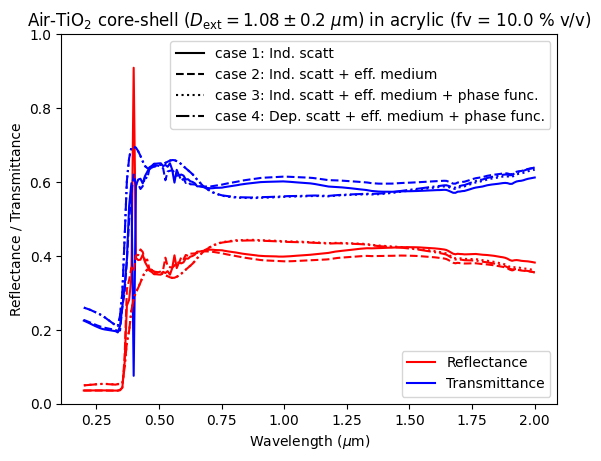

In [18]:
R_out = [Rt_c1, Rt_c2, Rt_c3, Rt_c4]
T_out = [Tt_c1, Tt_c2, Tt_c3, Tt_c4]
style = ['-','--',':','-.']
case_labels = ['case 1: Ind. scatt', 
               'case 2: Ind. scatt + eff. medium', 
               'case 3: Ind. scatt + eff. medium + phase func.', 
               'case 4: Dep. scatt + eff. medium + phase func.']

# Plot data
for i in range(len(R_out)):
    plt.plot(lam, R_out[i], linestyle=style[i], color='r')
    plt.plot(lam, T_out[i], linestyle=style[i], color='b')

# Create custom legend elements
from matplotlib.lines import Line2D

# Legend elements for cases (line styles)
case_elements = [Line2D([0], [0], color='black', linestyle=style[i], label=case_labels[i]) 
                 for i in range(len(style))]

# Legend elements for properties (colors)
prop_elements = [Line2D([0], [0], color='r', label='Reflectance'),
                 Line2D([0], [0], color='b', label='Transmittance')]

# Create legends
legend1 = plt.legend(handles=case_elements, loc='upper right')
legend2 = plt.legend(handles=prop_elements, loc='lower right')

# Add first legend back
plt.gca().add_artist(legend1)

plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Reflectance / Transmittance')
plt.title(f'Air-TiO$_2$ core-shell ($D_\mathrm{{ext}} = {mean_D2}\\pm{std_D}$ $\\mu$m) in acrylic (fv = {fv*100:.1f} % v/v)')
plt.ylim(0,1)
plt.show()